# Trained With Masked Input

Notebook written by Hans Walker and Marcin Abram (2022).

## 1. Introduction

### Motivation

During the training, neural networks tend to first learn the most important relations between data features and observed outcomes. If the model capacity is large enough, with advancing training the network discovers and learns progressively more and more subtle relations. In this work, we test the following hypothesis. We believe that during the training, networks might overly relay on some particular, strong features. This overreliance might impair the robustness of the network and might hurt the overall accuracy, especially if some of the strong features turn to be spurious. By distributing the focus of the network over many different features during the training, we hope to improve the robustness of the final model.  

### Approach

The main idea is to mask the most important features during the training, forcing the model to focus on the remaining features. We measure the feature importance by looking at the direct gradient in each training step. The masks are not permanent and are re-evaluated in each epoch.


### Scope of the Work

 1. Introduction
 2. Library Imports
 3. Data Preprocessing
 4. Data Masking Demonstration
 5. Baseline Evaluation
 6. Training With Masked Input
 7. Discussion
 8. Summary

## 2. Library Imports

We will pre-load all libraries that we will use in that notebook.

The notebook was tested with python 3.8, CUDA 10.1 and with the following package versions:

    Package                           Version
    --------------------------------- ----------
    numpy                             1.18.5
    pandas                            1.1.5
    scikit-image                      0.18.0
    scikit-learn                      0.23.2
    scipy                             1.4.1
    tensorflow-gpu                    2.3.0
    tensorflow-hub                    0.10.0

In [1]:
import collections
import random
import sys
import time

import numpy
import tensorflow
import pandas

# Graphic libraries
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## 3. Data Preprocessing

In [2]:
"""Define global parameters."""
batch_size = 32

In [3]:
"""Prepare datasets."""
(train_data, train_labels), (test_data, test_labels) = tensorflow.keras.datasets.cifar10.load_data()

train_data = train_data/255.
test_data = test_data/255.

train_dataset = tensorflow.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = tensorflow.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.batch(batch_size)

# sanity check
assert train_data.min() >= 0
assert train_data.max() <= 1

# print shapes
train_dataset, test_dataset

(<BatchDataset shapes: ((None, 32, 32, 3), (None, 1)), types: (tf.float64, tf.uint8)>,
 <BatchDataset shapes: ((None, 32, 32, 3), (None, 1)), types: (tf.float64, tf.uint8)>)

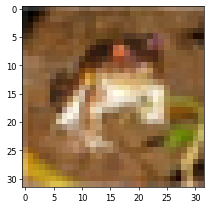

In [4]:
"""Plot example."""
plt.figure(dpi=60)
plt.imshow(train_data[0], interpolation=None)

## 4. Data Masking Demonstration

In [5]:
def mask_data(data, gradients, n=1, height=32, width=32):
    """Mask Data.
    
    Proposed and first implemented by Hans Walker.
    
    WARNING: This only work if eager execution is enabled in tensorflow.
    TODO: Try to re-write it so it is compatible with the graph execution in tensorflow.
    """
    grad = tensorflow.cast(gradients, dtype=tensorflow.float32)  # without that there is a warning
    line_grad = tensorflow.keras.layers.Flatten()(grad).numpy()
    
    # Getting the max (absolute) value index
    max_index = numpy.argmax(line_grad, axis=1) # Why do you have abs?
    
    #The mask is applied to n pixels out from the center
    #(so an 2n+1 by 2n+1 box) across all 3 color channels
    mask = numpy.ones((len(data), height, width, 3))
    for i, j in enumerate(max_index):
        
        #Converting the index gotten into an x,y index for the ith image
        j %= (height*width)
        column = j%width
        row = j//width
        
        # Create a boolean mask
        trunkate = lambda x: x if x>0 else 0
        mask[i, trunkate(row-n):row+n+1, trunkate(column-n):column+n+1, :] = 0

    return tensorflow.where(mask, data, tensorflow.zeros_like(data))

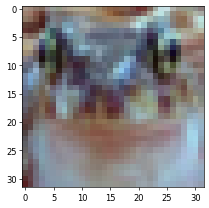

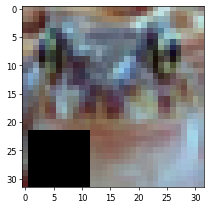

CPU times: user 847 ms, sys: 435 ms, total: 1.28 s
Wall time: 1.06 s


In [6]:
%%time

def get_dummy_model():
    """Define and compile the smalles model compatible with the input and output of the problem."""
    model = tensorflow.keras.models.Sequential()
    model.add(tensorflow.keras.layers.Flatten(input_shape=(32, 32, 3)))
    model.add(tensorflow.keras.layers.Dense(10))
    return model


# Instantiate an optimizer.
optimizer = tensorflow.keras.optimizers.Adam()

# Instantiate a loss function.
loss = tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = tensorflow.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tensorflow.keras.metrics.SparseCategoricalAccuracy()

# Prepare the model
model = get_dummy_model()

# Demonstrate the masking
for x, y in train_dataset.take(1):
    plt.figure(dpi=60)
    plt.imshow(x[0])
    plt.show()

    with tensorflow.GradientTape() as tape:
        tape.watch(x)
        logits = model(x, training=False)
        loss_value = loss(y, logits)
    
    grad = tape.gradient(loss_value, x)
    v = mask_data(x, grad, n=5)
    
    plt.figure(dpi=60)
    plt.imshow(v[0])
    plt.show()

## 5. Baseline Evaluation

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Flatten, Activation


def get_model():
    """Get a medium model."""
    model = Sequential()
    model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu", input_shape=(32, 32, 3)))
    model.add(Dropout(0.4))
    model.add(Conv2D(32, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, (3, 3), strides=1, padding="same", activation="relu"))
    model.add(Dropout(0.4))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(10))
    
    return model

In [8]:
# Instantiate an optimizer.
optimizer = tensorflow.keras.optimizers.Adam()

# Instantiate a loss function.
loss = tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = tensorflow.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tensorflow.keras.metrics.SparseCategoricalAccuracy()

# Prepare the model
base_model = get_model()
base_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)       

In [9]:
@tensorflow.function
def train_step(x, y):
    """Train step."""
    global base_model
    model = base_model
    
    with tensorflow.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value


@tensorflow.function
def test_step(x, y):
    """Test step."""
    global base_model
    model = base_model
    
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

In [10]:
base_model_log = []

epochs = 20
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 200 batches.
        if step % 200 == 0:
            print('.', end='')

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("\nTraining acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in test_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))
    
    base_model_log.append({'epoch': epoch, 'val_accuracy': val_acc})


Start of epoch 0
........
Training acc over epoch: 0.4001
Validation acc: 0.4589
Time taken: 8.78s

Start of epoch 1
........
Training acc over epoch: 0.5580
Validation acc: 0.5450
Time taken: 6.53s

Start of epoch 2
........
Training acc over epoch: 0.6118
Validation acc: 0.5792
Time taken: 7.20s

Start of epoch 3
........
Training acc over epoch: 0.6366
Validation acc: 0.6357
Time taken: 7.32s

Start of epoch 4
........
Training acc over epoch: 0.6534
Validation acc: 0.6306
Time taken: 6.97s

Start of epoch 5
........
Training acc over epoch: 0.6673
Validation acc: 0.5911
Time taken: 6.74s

Start of epoch 6
........
Training acc over epoch: 0.6761
Validation acc: 0.6556
Time taken: 6.75s

Start of epoch 7
........
Training acc over epoch: 0.6797
Validation acc: 0.6272
Time taken: 6.53s

Start of epoch 8
........
Training acc over epoch: 0.6869
Validation acc: 0.6628
Time taken: 6.40s

Start of epoch 9
........
Training acc over epoch: 0.6879
Validation acc: 0.6887
Time taken: 6.61s


## 6. Training With Masked Input

In [11]:
# Instantiate an optimizer.
optimizer = tensorflow.keras.optimizers.Adam()

# Instantiate a loss function.
loss = tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = tensorflow.keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = tensorflow.keras.metrics.SparseCategoricalAccuracy()

# Prepare the model
masked_model = get_model()

In [12]:
#@tensorflow.function  # Unfortunately, we can not use it right now
def train_step(x, y):
    """Train step."""
    global masked_model
    model = masked_model
    
    # calculate the mask
    with tensorflow.GradientTape() as tape:
        tape.watch(x)
        loss_value = model(x, training=False)
    
    # masking the data
    grads = tape.gradient(loss_value, x)
    x_masked = mask_data(x, grads, n=1)  
    
    # main training step
    with tensorflow.GradientTape() as tape:
        logits = model(x_masked, training=True)
        loss_value = loss(y, logits)
        
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    
    return loss_value


#@tensorflow.function  # Unfortunately, we can not use it right now
def test_step(x, y):
    """Test step."""
    global masked_model
    model = masked_model
    
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

In [13]:
masked_model_log = []

epochs = 20
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 200 batches.
        if step % 200 == 0:
            print('.', end='')

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in test_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))
    
    masked_model_log.append({'epoch': epoch, 'val_accuracy': val_acc})


Start of epoch 0
........Training acc over epoch: 0.3870
Validation acc: 0.4357
Time taken: 40.21s

Start of epoch 1
........Training acc over epoch: 0.5316
Validation acc: 0.4839
Time taken: 41.43s

Start of epoch 2
........Training acc over epoch: 0.5849
Validation acc: 0.5359
Time taken: 40.60s

Start of epoch 3
........Training acc over epoch: 0.6189
Validation acc: 0.5954
Time taken: 40.56s

Start of epoch 4
........Training acc over epoch: 0.6386
Validation acc: 0.6283
Time taken: 41.56s

Start of epoch 5
........Training acc over epoch: 0.6537
Validation acc: 0.6200
Time taken: 43.33s

Start of epoch 6
........Training acc over epoch: 0.6626
Validation acc: 0.6269
Time taken: 41.89s

Start of epoch 7
........Training acc over epoch: 0.6683
Validation acc: 0.6311
Time taken: 42.59s

Start of epoch 8
........Training acc over epoch: 0.6747
Validation acc: 0.6305
Time taken: 43.83s

Start of epoch 9
........Training acc over epoch: 0.6781
Validation acc: 0.6378
Time taken: 43.39s


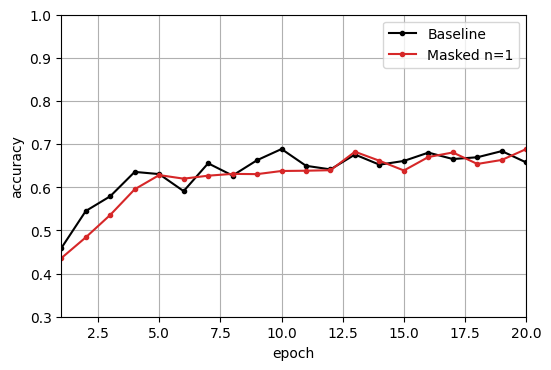

In [14]:
"""Summary."""
plt.figure(dpi=100)

x = numpy.linspace(1, 20, 20)
plt.plot(x, [y['val_accuracy'] for y in base_model_log], '.-', color='black', label='Baseline')
plt.plot(x, [y['val_accuracy'] for y in masked_model_log], '.-', color='tab:red', label='Masked n=1')

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.xlim([1, 20])
plt.ylim([0.3, 1.0])
plt.grid()
plt.legend()
plt.show()

**Interpretation:** During the training we masked the input using 3x3 patches. It seems there is no statistical difference between the baseline and the tested approach. Both models train with similar rate, and after 20 epoches, they reach similar accuracy of about `0.68`. In this one run, it seems like the training with masked input might increase the stability of the training (the red line in the first 10 epoches is almost always monotonically increasing, while the black one oscillates). However, we can not say for sure observing just one run - we would have to repeat this experiment several times to test this hypothesis.

## 7. Discussion

It seems like the effect of input masking on training is rather small. The model can recover the missing information and achieve similar accuracy to the baseline approach. Note, that we used a heavily regularized model (40% dropout after each convolution). Masked input can also work as an implicit regularization. Maybe the gain that we had observed previously was related to regularization (meaning, that a simple model without dropout trained on masked input overperforms a baseline model without dropout; however, adding dropout, we close that gap).


## 8. Summary

Further tests are needed before we will be able to write the final conclusions.